# Explore Spark Exercises

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

In [4]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [5]:
df = wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


In [7]:
print(f'df shape: {df.count()} rows, {len(df.columns)} columns')

df shape: 841704 rows, 20 columns


In [8]:
df.show(1, vertical = True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616         
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



## 1. How many different cases are there, by department?

In [10]:
# using .groupby() function and then aggregating by count to get cases by dept
df.groupby('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [16]:
# saving the aggregated data above to a pandas df
cases_by_dept = df.groupby('department').count().toPandas().set_index('department')['count']

# looking at the pandas df
cases_by_dept

department
Solid Waste                 279270
Animal Care Services        116915
Trans & Cap Improvements     96193
Parks & Recreation           19907
Customer Service              2849
Metro Health                  5163
City Council                    33
DSD/Code Enforcement        321374
Name: count, dtype: int64

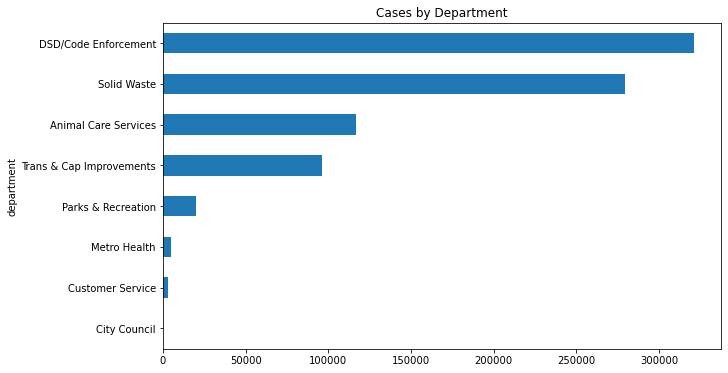

In [24]:
# visualizing the above data
cases_by_dept.sort_values().plot.barh(figsize = (10, 6))
plt.title('Cases by Department')
plt.show()

## 2. Does the percentage of cases that are late vary by department?

In [36]:
# aggregating the cases late and not late department averages in spark
df.groupby('department')\
        .pivot('case_late')\
        .agg(round(mean('case_lifetime'), 2))\
    .show()

+--------------------+------+------+
|          department| false|  true|
+--------------------+------+------+
|         Solid Waste|  2.11| 13.67|
|Animal Care Services|  0.25| 26.97|
|Trans & Cap Impro...|  7.82| 30.22|
|    Customer Service| 16.83|134.21|
|  Parks & Recreation|   5.9| 36.53|
|        Metro Health|  4.87|  16.8|
|        City Council|138.94|  null|
|DSD/Code Enforcement| 11.38| 98.71|
+--------------------+------+------+



In [43]:
# saving the above data to a pandas df
case_late_by_dept = df.groupby('department')\
        .pivot('case_late')\
        .agg(round(mean('case_lifetime'), 2))\
        .toPandas()\
.set_index('department')

# changing column names
case_late_by_dept.columns = ['not_late', 'late']

# looking at df
case_late_by_dept

,not_late,late
department,,
Solid Waste,2.11,13.67
Animal Care Services,0.25,26.97
Trans & Cap Improvements,7.82,30.22
Customer Service,16.83,134.21
Parks & Recreation,5.90,36.53
Metro Health,4.87,16.80
City Council,138.94,NaN
DSD/Code Enforcement,11.38,98.71


<AxesSubplot:ylabel='department'>

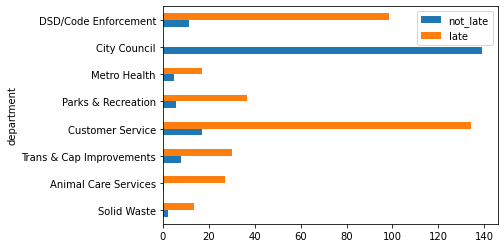

In [44]:
# visualizing data
case_late_by_dept.plot.barh()

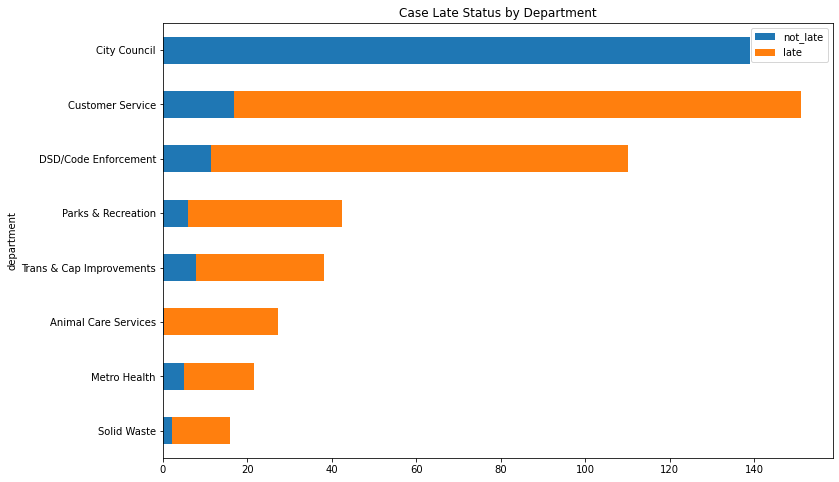

In [59]:
# changing the formatting
case_late_by_dept.sort_values(by = 'late').plot.barh(figsize = (12, 8), stacked = True)
plt.title('Case Late Status by Department')
plt.show()

## 3. On average, how late are the late cases by department?
- group data by `department`
- filter to only show results where `casle_late` == `True`
- look at the average `num_days_late`

In [63]:
# looking at the first row of data, veritcally
df.show(1, vertical = True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616         
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [65]:
# grouping data by department and looking at average number of days late, by department
df.groupby('department').agg(mean('num_days_late')).show()

+--------------------+-------------------+
|          department| avg(num_days_late)|
+--------------------+-------------------+
|         Solid Waste|-2.1938644240225362|
|Animal Care Services| -226.1654977071745|
|Trans & Cap Impro...|  -20.5097935017854|
|  Parks & Recreation| -5.283345998745914|
|    Customer Service|  59.49019459221512|
|        Metro Health| -4.904223205386018|
|        City Council|               null|
|DSD/Code Enforcement| -38.32346772537443|
+--------------------+-------------------+



In [85]:
# filtering the above data to only show cases where case_late == True
avg_late_by_dept = df.filter(df.case_late == True)\
    .groupby('department')\
    .agg(round(mean('num_days_late'), 2).alias('days_late'))\
.toPandas()\
.set_index('department')\
.sort_values(by = 'days_late', ascending = False)

avg_late_by_dept

,days_late
department,
Customer Service,87.68
DSD/Code Enforcement,49.38
Animal Care Services,23.46
Parks & Recreation,22.35
Trans & Cap Improvements,10.60
Solid Waste,7.19
Metro Health,6.54


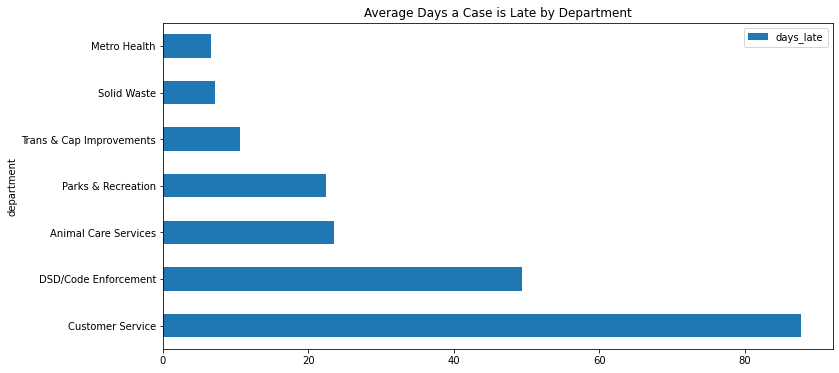

In [91]:
# visualizing the data
avg_late_by_dept.plot.barh(figsize = (12, 6))
plt.title('Average Days a Case is Late by Department')
plt.show()

## 4a. What is the service type that is the most late? 
## 4b. Just for Parks & Rec?

## 5a. For the DSD/Code Enforcement department, what are the most common service request types? 
## 5b. Look at other departments too.

## 6. Does whether or not its a weekend matter for when a case is opened/closed?

## 7. On average, how many cases are opened a day for the Customer Service department?

## 8. Does the number of service requests for the solid waste department vary by day of the week?